#Tugas Besar PCD Klasifikasi Nominal Rupiah Menggunakan Teknik Pemrosesan Citra

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


##Libraries

In [164]:
!python -m pip show pickle

In [148]:
import os
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial import distance
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
# from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import LearningCurveDisplay, learning_curve, ValidationCurveDisplay, validation_curve

from skopt import BayesSearchCV
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer

import pickle


###library misc

In [165]:
print(pickle.format_version)

4.0


In [156]:
!python --version

Python 3.10.12


In [154]:
# !pip install session-info
# import session_info
# session_info.show()
# !pipreqs
# session_info.show(write_req_file=True, req_file_name='requirements.txt')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=31da6d2bc302a2d4f731e4a6473f12b85f289b2f47755019539c62f3227a27f9
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
/bin/bash: line 1: pipreqs: command not found


In [153]:
# !pip freeze --local > requirements2.txt

In [103]:
# !pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.7 MB/s eta 0:00:00


##Load dataset

In [ ]:
# !unzip '/content/drive/MyDrive/Semester 7/pcd/project/dataset.zip' -d '/content/drive/MyDrive/Semester 7/pcd/project/ds'

In [4]:
ds_path = '/content/drive/MyDrive/Semester 7/pcd/project/ds/Uang Baru'
processed_ds = '/content/drive/MyDrive/Semester 7/pcd/project/processed_ds'

In [ ]:
total = 0
for dir in os.listdir(ds_path):
  total += len(os.listdir(os.path.join(ds_path, dir)))
print(total)

In [ ]:
total = 0
for dir in os.listdir(processed_ds):
  total += len(os.listdir(os.path.join(ds_path, dir)))
print(total)

## Image Processing and Feature Extraction

###SIFT

In [67]:
label_dict = {folder: idx for idx, folder in enumerate(os.listdir(processed_ds))}
label_dict

{'1000': 0,
 '2000': 1,
 '5000': 2,
 '10000': 3,
 '20000': 4,
 '50000': 5,
 '100000': 6}

In [68]:
# del len
total = 0
for cat in os.listdir(processed_ds):

  total += len(os.listdir(os.path.join(processed_ds, cat)))
  print(f"{cat} : {len(os.listdir(os.path.join(processed_ds, cat)))}")
print(total)

1000 : 184
2000 : 167
5000 : 227
10000 : 183
20000 : 214
50000 : 171
100000 : 227
1373


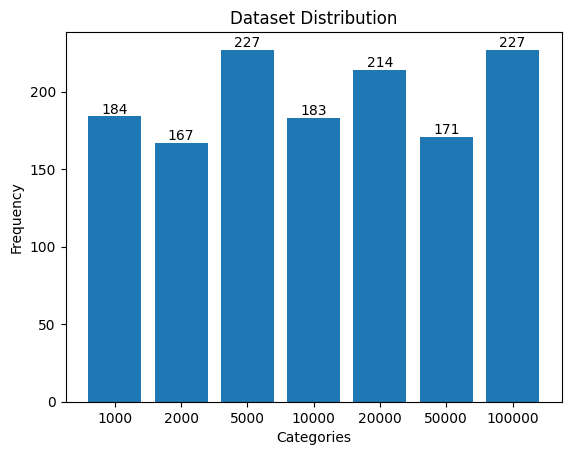

In [198]:
fig, ax = plt.subplots()
dataset_spread = {cat : total for cat, total in zip(os.listdir(processed_ds), [len(os.listdir(os.path.join(processed_ds, cat))) for cat in os.listdir(processed_ds)])}

# display frequency in each bar
for i, v in enumerate(dataset_spread.values()):
    ax.text(i, v, str(v), ha='center', va='bottom')
ax.bar(dataset_spread.keys(), dataset_spread.values())
ax.set_xlabel('Categories')

ax.set_ylabel('Frequency')
ax.set_title('Dataset Distribution')

plt.show()

In [69]:
class_list = os.listdir(processed_ds)
class_list.sort()

In [132]:
SIFT = cv.SIFT_create(nfeatures=200, enable_precise_upscale = True)

all_descriptors = []
for label_name, label_idx in label_dict.items():
  print(f"processing {label_name}...")
  count = 1
  folder_path = os.path.join(ds_path, label_name)
  for img_file in os.listdir(folder_path):
    print(f"processing file {count}...")
    img_path = os.path.join(folder_path, img_file)
    image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (224, 224), interpolation=cv.INTER_LINEAR)
    _, descriptors = SIFT.detectAndCompute(image, None)
    if descriptors is not None:
      all_descriptors.append(descriptors)
    count +=1
all_descriptors = np.vstack(all_descriptors)
print(all_descriptors.shape)

processing 1000...
processing file 1...
processing file 2...
processing file 3...
processing file 4...
processing file 5...
processing file 6...
processing file 7...
processing file 8...
processing file 9...
processing file 10...
processing file 11...
processing file 12...
processing file 13...
processing file 14...
processing file 15...
processing file 16...
processing file 17...
processing file 18...
processing file 19...
processing file 20...
processing file 21...
processing file 22...
processing file 23...
processing file 24...
processing file 25...
processing file 26...
processing file 27...
processing file 28...
processing file 29...
processing file 30...
processing file 31...
processing file 32...
processing file 33...
processing file 34...
processing file 35...
processing file 36...
processing file 37...
processing file 38...
processing file 39...
processing file 40...
processing file 41...
processing file 42...
processing file 43...
processing file 44...
processing file 45...


####clustering1

In [196]:
# clustering k-means
k = 150
kmeans = KMeans(n_clusters=k, algorithm="elkan", verbose=1)
kmeans.fit(all_descriptors)

Initialization complete
Iteration 0, inertia 22228117504.0
Iteration 1, inertia 15666206720.0
Iteration 2, inertia 15323632640.0
Iteration 3, inertia 15173187584.0
Iteration 4, inertia 15078257664.0
Iteration 5, inertia 15016704000.0
Iteration 6, inertia 14975593472.0
Iteration 7, inertia 14947369984.0
Iteration 8, inertia 14927312896.0
Iteration 9, inertia 14911985664.0
Iteration 10, inertia 14899611648.0
Iteration 11, inertia 14884837376.0
Iteration 12, inertia 14858311680.0
Iteration 13, inertia 14844029952.0
Iteration 14, inertia 14833709056.0
Iteration 15, inertia 14824065024.0
Iteration 16, inertia 14813699072.0
Iteration 17, inertia 14804742144.0
Iteration 18, inertia 14798482432.0
Iteration 19, inertia 14793479168.0
Iteration 20, inertia 14788090880.0
Iteration 21, inertia 14783234048.0
Iteration 22, inertia 14779558912.0
Iteration 23, inertia 14776649728.0
Iteration 24, inertia 14774349824.0
Iteration 25, inertia 14771625984.0
Iteration 26, inertia 14767119360.0
Iteration 27, 

KMeans(algorithm='elkan', n_clusters=150, verbose=1)

In [168]:
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

In [173]:
import joblib

In [194]:
joblib.dump(kmeans, 'kmeans_model2.joblib')


['kmeans_model2.joblib']

In [195]:
loaded_model = joblib.load('kmeans_model2.joblib')
type(loaded_model)

sklearn.cluster._kmeans.KMeans

In [93]:
# for desc in all_descriptors:
#   desc = desc.reshape(1, -1)
#   words = kmeans.predict(desc)
#   histogram, _  = np.histogram(words, bins=np.arange(k+1))
#   image_histograms.append(histogram)

In [94]:
# print("Number of histograms:", len(image_histograms))
# print("Number of labels:", len(labels))

# X = np.array(image_histograms)
# y = np.array(labels)
# print("Shapes of X and y:", X.shape, y.shape)

Number of histograms: 242419
Number of labels: 1371
Shapes of X and y: (242419, 150) (1371,)


In [134]:
image_histograms = []
labels = []
for label_name, label_idx in label_dict.items():
  folder_path = os.path.join(ds_path, label_name)
  print(f"processing {label_name}...")
  count = 1
  for img_file in os.listdir(folder_path):
    print(f"processing file {count}...")
    img_path = os.path.join(folder_path, img_file)
    image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (224, 224), interpolation=cv.INTER_LINEAR)
    _, descriptors = SIFT.detectAndCompute(image, None)
    if descriptors is not None:
      words = kmeans.predict(descriptors)
      histogram, _ = np.histogram(words, bins=np.arange(k+1))
      image_histograms.append(histogram)
      labels.append(label_idx)
    count+=1
print("Number of histograms:", len(image_histograms))
print("Number of labels:", len(labels))

X = np.array(image_histograms)
y = np.array(labels)
print("Shapes of X and y:", X.shape, y.shape)

processing 1000...
processing file 1...
processing file 2...
processing file 3...
processing file 4...
processing file 5...
processing file 6...
processing file 7...
processing file 8...
processing file 9...
processing file 10...
processing file 11...
processing file 12...
processing file 13...
processing file 14...
processing file 15...
processing file 16...
processing file 17...
processing file 18...
processing file 19...
processing file 20...
processing file 21...
processing file 22...
processing file 23...
processing file 24...
processing file 25...
processing file 26...
processing file 27...
processing file 28...
processing file 29...
processing file 30...
processing file 31...
processing file 32...
processing file 33...
processing file 34...
processing file 35...
processing file 36...
processing file 37...
processing file 38...
processing file 39...
processing file 40...
processing file 41...
processing file 42...
processing file 43...
processing file 44...
processing file 45...


##Classification

###split data

In [135]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(1098, 150), (1098,)
Test data and target sizes: 
(275, 150), (275,)


In [136]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

###Random Forest Classifier

In [112]:
# dari bovw sift 1
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_features='log2', criterion='entropy', min_samples_split=5)
rf_clf.fit(X_train_scaled, y_train)

rf_accuracy = rf_clf.score(X_test_scaled, y_test)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

Random Forest Accuracy: 41.82%


In [110]:
# dari bovw sift 1
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_features='log2', criterion='entropy', min_samples_split=5)
rf_clf.fit(X_train, y_train)

rf_accuracy = rf_clf.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

Random Forest Accuracy: 42.18%


In [92]:
# dari bovw sift 2
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_features='log2', criterion='entropy', min_samples_split=5)
rf_clf.fit(train_x, train_y)

rf_accuracy = rf_clf.score(test_x, test_y)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

Random Forest Accuracy: 42.86%


In [113]:
opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators': Categorical([100, 150, 200]),
        'max_depth': Integer(1, 10),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 5),
        'max_features': Categorical(['sqrt', 'log2']),
        'criterion': Categorical(['gini', 'entropy'])
    },
    n_iter=100,
    cv=5,
    random_state=0,
    verbose=3
)

history = opt.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=200;, score=0.359 total time=   1.0s
[CV 2/5] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=200;, score=0.416 total time=   1.0s
[CV 3/5] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=200;, score=0.365 total time=   1.0s
[CV 4/5] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=200;, score=0.342 total time=   1.0s
[CV 5/5] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=200;, score=0.315 total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_es

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 10, 'log2', 1, 2, 200] before, using random point ['entropy', 7, 'log2', 2, 3, 200]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200;, score=0.377 total time=   0.7s
[CV 2/5] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200;, score=0.370 total time=   0.6s
[CV 3/5] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200;, score=0.379 total time=   0.7s
[CV 4/5] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200;, score=0.301 total time=   0.7s
[CV 5/5] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200;, score=0.365 total time=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 9, 'log2', 1, 10, 200] before, using random point ['entropy', 9, 'sqrt', 2, 3, 100]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.359 total time=   0.5s
[CV 2/5] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.374 total time=   0.5s
[CV 3/5] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.384 total time=   0.6s
[CV 4/5] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.352 total time=   0.8s
[CV 5/5] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.411 total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=9, max_features=log2, min_samples_leaf=1, min_samples_split=10, n

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 9, 'sqrt', 5, 2, 150] before, using random point ['gini', 1, 'log2', 4, 8, 100]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.232 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.215 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.187 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.219 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.215 total time=   0.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=150

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 9, 'sqrt', 1, 2, 150] before, using random point ['gini', 1, 'log2', 5, 4, 150]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150;, score=0.264 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150;, score=0.201 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150;, score=0.210 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150;, score=0.237 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150;, score=0.205 total time=   0.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200;

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 10, 'sqrt', 1, 2, 150] before, using random point ['entropy', 10, 'log2', 3, 3, 150]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150;, score=0.377 total time=   0.6s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150;, score=0.406 total time=   0.5s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150;, score=0.443 total time=   0.6s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150;, score=0.315 total time=   0.6s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150;, score=0.374 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 10, 'sqrt', 1, 2, 150] before, using random point ['gini', 3, 'sqrt', 1, 2, 200]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.264 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.315 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.256 total time=   0.5s
[CV 4/5] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.247 total time=   0.5s
[CV 5/5] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.251 total time=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=200;

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 9, 'sqrt', 1, 2, 150] before, using random point ['entropy', 9, 'log2', 5, 7, 200]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=9, max_features=log2, min_samples_leaf=5, min_samples_split=7, n_estimators=200;, score=0.364 total time=   0.7s
[CV 2/5] END criterion=entropy, max_depth=9, max_features=log2, min_samples_leaf=5, min_samples_split=7, n_estimators=200;, score=0.374 total time=   0.7s
[CV 3/5] END criterion=entropy, max_depth=9, max_features=log2, min_samples_leaf=5, min_samples_split=7, n_estimators=200;, score=0.434 total time=   0.6s
[CV 4/5] END criterion=entropy, max_depth=9, max_features=log2, min_samples_leaf=5, min_samples_split=7, n_estimators=200;, score=0.361 total time=   0.6s
[CV 5/5] END criterion=entropy, max_depth=9, max_features=log2, min_samples_leaf=5, min_samples_split=7, n_estimators=200;, score=0.342 total time=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_est

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 8, 'log2', 1, 2, 150] before, using random point ['gini', 2, 'sqrt', 2, 8, 150]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=0.268 total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=0.242 total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=0.247 total time=   0.6s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=0.247 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=0.247 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 10, 'sqrt', 1, 2, 150] before, using random point ['entropy', 7, 'sqrt', 4, 5, 200]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.341 total time=   1.4s
[CV 2/5] END criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.374 total time=   1.2s
[CV 3/5] END criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.356 total time=   1.2s
[CV 4/5] END criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.333 total time=   1.0s
[CV 5/5] END criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.342 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 10, 'sqrt', 1, 10, 150] before, using random point ['entropy', 2, 'log2', 4, 3, 150]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150;, score=0.255 total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150;, score=0.247 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150;, score=0.237 total time=   0.3s
[CV 4/5] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150;, score=0.233 total time=   0.3s
[CV 5/5] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150;, score=0.219 total time=   0.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 9, 'sqrt', 1, 2, 150] before, using random point ['gini', 5, 'sqrt', 4, 9, 150]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=9, n_estimators=150;, score=0.323 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=9, n_estimators=150;, score=0.370 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=9, n_estimators=150;, score=0.333 total time=   0.5s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=9, n_estimators=150;, score=0.315 total time=   0.5s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=9, n_estimators=150;, score=0.320 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 10, 'sqrt', 1, 2, 150] before, using random point ['gini', 8, 'sqrt', 2, 7, 200]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=200;, score=0.373 total time=   0.7s
[CV 2/5] END criterion=gini, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=200;, score=0.393 total time=   0.8s
[CV 3/5] END criterion=gini, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=200;, score=0.379 total time=   0.8s
[CV 4/5] END criterion=gini, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=200;, score=0.338 total time=   0.8s
[CV 5/5] END criterion=gini, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=200;, score=0.347 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 9, 'sqrt', 1, 2, 150] before, using random point ['entropy', 4, 'log2', 2, 9, 200]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=9, n_estimators=200;, score=0.314 total time=   0.5s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=9, n_estimators=200;, score=0.338 total time=   0.5s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=9, n_estimators=200;, score=0.311 total time=   0.5s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=9, n_estimators=200;, score=0.274 total time=   0.5s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=9, n_estimators=200;, score=0.256 total time=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_es

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 9, 'sqrt', 1, 2, 150] before, using random point ['gini', 6, 'sqrt', 3, 8, 100]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=0.332 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=0.374 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=0.388 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=0.338 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=0.370 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 9, 'sqrt', 1, 2, 150] before, using random point ['gini', 7, 'log2', 2, 8, 200]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=0.368 total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=0.402 total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=0.420 total time=   0.6s
[CV 4/5] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=0.338 total time=   0.6s
[CV 5/5] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=0.356 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 9, 'sqrt', 1, 2, 150] before, using random point ['entropy', 3, 'sqrt', 3, 7, 100]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=100;, score=0.255 total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=100;, score=0.288 total time=   0.3s
[CV 3/5] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=100;, score=0.288 total time=   0.3s
[CV 4/5] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=100;, score=0.274 total time=   0.3s
[CV 5/5] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=100;, score=0.269 total time=   0.3s


In [114]:
history.best_params_

OrderedDict([('criterion', 'gini'),
             ('max_depth', 10),
             ('max_features', 'log2'),
             ('min_samples_leaf', 1),
             ('min_samples_split', 2),
             ('n_estimators', 150)])

In [115]:
history.score(X_test_scaled, y_test)

0.44727272727272727

In [138]:
# final best model
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42, max_features='log2', criterion='gini', min_samples_split=2, min_samples_leaf=1)
rf_clf.fit(X_train_scaled, y_train)

rf_accuracy = rf_clf.score(X_test_scaled, y_test)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

Random Forest Accuracy: 81.82%


In [140]:
#save model
with open('rupiah_nominal_cls_model_82pt.pkl', 'wb') as file:
    pickle.dump(rf_clf, file)

In [188]:
joblib.dump(rf_clf, '/content/drive/MyDrive/Semester 7/pcd/project/rupiah_nominal_cls_model_82pt.joblib')

['/content/drive/MyDrive/Semester 7/pcd/project/rupiah_nominal_cls_model_82pt.joblib']

In [170]:
rf_clf.classes_

array([0, 1, 2, 3, 4, 5, 6])

sklearn.ensemble._forest.RandomForestClassifier

##Evaluation

In [142]:
y_pred = rf_clf.predict(X_test_scaled)

In [167]:
len(y_pred)

275

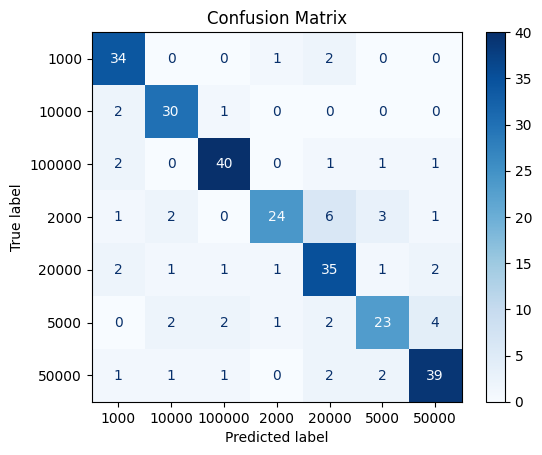

In [172]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_list)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

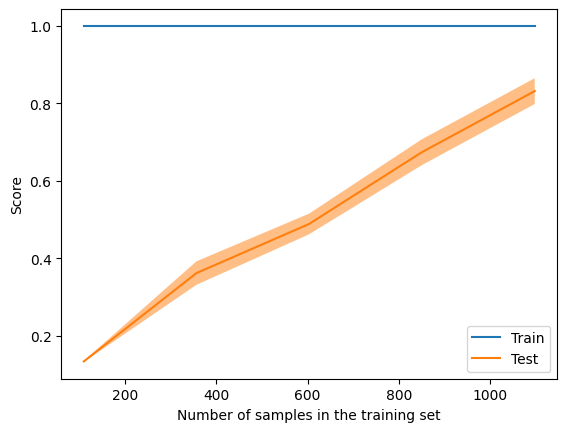

In [145]:
train_sizes, train_scores, test_scores = learning_curve(
    rf_clf, X, y)
display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()

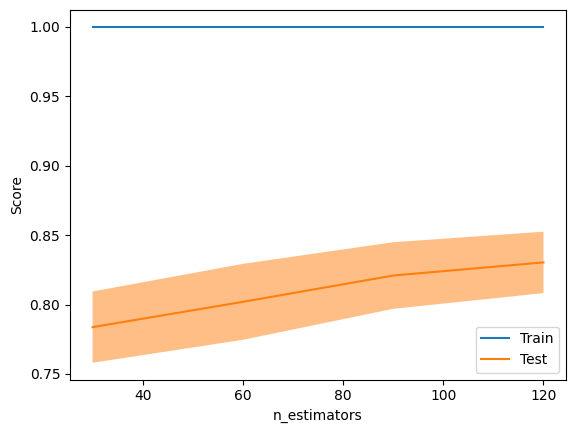

In [150]:
param_name, param_range = "n_estimators", np.arange(0, 150, 30)
train_scores, test_scores = validation_curve(
    rf_clf, X, y, param_name=param_name, param_range=param_range
)
display = ValidationCurveDisplay(
    param_name=param_name, param_range=param_range,
    train_scores=train_scores, test_scores=test_scores, score_name="Score"
)
display.plot()
plt.show()

##misc


###Local Binary Pattern (LBP)

In [ ]:
from skimage.feature import local_binary_pattern

def lbp_histogram_spatial(image, P, R, grid_size, n_bins, method="default"):
    # Convert image to grayscale if it isn't already
    if len(image.shape) > 2:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Get the dimensions for the grid
    height, width = image.shape
    grid_height, grid_width = height // grid_size[0], width // grid_size[1]

    # Placeholder for concatenated histograms
    histograms = []

    # Loop through each cell in the grid
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Define cell region
            cell = image[i * grid_height:(i + 1) * grid_height, j * grid_width:(j + 1) * grid_width]

            # Compute LBP for the cell
            lbp = local_binary_pattern(cell, P, R, method=method)

            # Calculate histogram for the cell and normalize
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
            hist = hist / hist.sum()  # Normalize

            # Append histogram to the list
            histograms.append(hist)

    # Concatenate all histograms into a single feature vector
    feature_vector = np.concatenate(histograms)
    return feature_vector

image_histograms = []
labels = []
R = 1
P = 8
grid_size = (8, 8)
n_bins = 16

for label_name in os.listdir(processed_ds):
    folder_path = os.path.join(processed_ds, label_name)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        lbp = lbp_histogram_spatial(gray, P, R, grid_size, n_bins)

        image_histograms.append(lbp)
        labels.append(label_name)


X = np.array(image_histograms)
y = np.array(labels)

print(X.shape)
print(y.shape)

In [ ]:
image_histograms = []
labels = []

SIFT = cv.SIFT_create(nfeatures=200, enable_precise_upscale = True)

all_descriptors = []
train_features_vectors = {}
test_features_vectors = {}
for label_name, label_idx in label_dict.items():
  count = 0
  train_features_vectors[label_name] = []
  test_features_vectors[label_name] = []
  folder_path = os.path.join(processed_ds, label_name)
  for img_file in os.listdir(folder_path):
      img_path = os.path.join(folder_path, img_file)
      image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
      img = cv.resize(img, (224, 224), interpolation=cv.INTER_LINEAR)
      _, descriptors = SIFT.detectAndCompute(image, None)
      if descriptors is not None:
          if count > 20:
              all_descriptors.append(descriptors)
              train_features_vectors[label_name].append(descriptors)
          else:
              test_features_vectors[label_name].append(descriptors)
          count += 1

all_descriptors = np.vstack(all_descriptors)
print(all_descriptors.shape)



(342734, 128)


In [ ]:
train_features_vectors['1000'][0]

array([[125.,   0.,   0., ...,   0.,   0.,   0.],
       [ 91.,   5.,   0., ...,   0.,   0.,   0.],
       [  4.,   0.,   2., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   8.,  12.,  19.],
       [  0.,   0.,   0., ...,  13.,  19.,  15.],
       [ 39.,  10.,  13., ...,   0.,   0.,   1.]], dtype=float32)

In [ ]:
len(all_descriptors[0])

128

In [ ]:
all_descriptors[1]

array([ 91.,   5.,   0.,   0.,   0.,   0.,   0.,   0., 187.,  17.,   0.,
         0.,   0.,   0.,   0.,   8., 110.,  17.,   4.,   1.,   0.,   0.,
         0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 107.,
         4.,   0.,   0.,   0.,   0.,   0.,   2., 187.,  11.,   1.,   3.,
        17.,   3.,   2.,  35.,  56.,  11.,  17.,  36.,  78.,   6.,   3.,
        17.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0., 112.,   0.,
         0.,   0.,   0.,   0.,   0.,  18., 187.,  22.,   6.,  11.,  26.,
         1.,   0.,  49.,  37.,  11.,   7.,  39., 174.,   1.,   0.,   2.,
         0.,   0.,   0.,   0.,   3.,   0.,   0.,   0., 115.,   4.,   0.,
         0.,   0.,   0.,   0.,   3., 187.,  17.,   1.,   3.,  12.,   0.,
         0.,  10.,  12.,   3.,   2.,   8., 112.,   5.,   0.,   0.,   0.,
         0.,   0.,   0.,   4.,   0.,   0.,   0.], dtype=float32)

In [ ]:
max = 0
min = 1000
for desc in all_descriptors:
  max = desc.max() if desc.max() > max else max
  min = desc.min() if desc.min() < min else min
print(min)
print(max)

0.0
254.0


In [ ]:

# A k-means clustering algorithm who takes 2 parameter which is number
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_
    return visual_words

# Takes the central points which is visual words
visual_words = kmeans(200, all_descriptors)

In [ ]:
print(visual_words[0], len(visual_words[0]))

[ 23.587029   28.265121   31.783398   25.90581    19.14262    19.494566
  24.338314   22.682255   32.84472    36.302803   35.048073   26.008558
  22.744389   25.676544   32.408447   31.90702    32.338257   28.159737
  24.704472   23.972042   27.341099   32.628113   35.275574   32.441475
  19.317724   17.110096   18.493984   22.635477   29.160864   30.521439
  28.187689   22.102097   21.827343   36.633266   52.11268    40.833782
  26.836262   24.300053   27.546465   19.539585   37.147522   60.787327
  85.12053    57.089516   22.339714   21.935135   28.047369   20.985657
 106.50053    66.24121    41.565712   23.187725   18.689434   23.406681
  25.7153     39.6492     22.332579   13.884249   18.153433   31.461504
  46.393116   47.902      35.540802   24.103827   19.730984   18.98159
  30.33382    23.026237   23.439278   39.87407    64.414955   40.418934
  26.465153   19.388294   41.003807   29.353031   20.433628   55.47694
  96.18129    58.425747  100.89296    44.339394   53.322018   32.7

In [ ]:
max = 0
min = 200
for words in visual_words:
  max = words.max() if words.max() > max else max
  min = words.min() if words.min() < min else min
print(min)
print(max)

0.6425419
167.8047


In [ ]:
#normalization
for i in range(len(visual_words)):
  for j in range(len(visual_words[i])):
    visual_words[i][j] = (visual_words[i][j] - min) / (max - min)

In [ ]:
np.zeros(5)

array([0., 0., 0., 0., 0.])

In [ ]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(200)
    for word in img_visual_words:
        # Find the closest visual word index
        word_index = np.argmin(np.linalg.norm(visual_words - word, axis=1))
        img_frequency_vector[word_index] += 1  # Increment the count for the closest word
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)
frequency_vectors.shape

(200, 200)

In [ ]:
frequency_vectors[3]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  18.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [ ]:
# Find the index of the closest central point to the each sift descriptor.
# Takes 2 parameters the first one is a sift descriptor and the second one is the array of central points in k means
# Returns the index of the closest central point.
def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i])
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i])
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

In [ ]:
# Takes 2 parameters. The first one is a dictionary that holds the descriptors that are separated class by class
# And the second parameter is an array that holds the central points (visual words) of the k means clustering
# Returns a dictionary that holds the histograms for each images that are separated class by class.
def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature

# Creates histograms for train data
bovw_train = image_class(train_features_vectors, visual_words)
# Creates histograms for test data
bovw_test = image_class(test_features_vectors, visual_words)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import HistGradientBoostingClassifier
import sklearn
knn_clf = sklearn.ensemble.HistGradientBoostingClassifier()
knn_clf.fit(X_train, y_train)
KNN_accuracy = knn_clf.score(X_test, y_test)
print(f"KNN Accuracy: {rf_accuracy * 100:.2f}%")

In [ ]:
clf = sklearn.svm.SVC()
clf.cit()

In [ ]:
!pip install tpot

In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12==24.10.*

In [ ]:
# TPOT Classifier
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=20, verbosity=3, population_size=5, random_state=123,
                      scoring='accuracy',
                      n_jobs=-1,
                      config_dict="TPOT cuML",
                      cv=5)
tpot.fit(X_train, y_train)

print(tpot.score(X_test, y_test))

In [ ]:
tpot.fitted_pipeline_

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
y_pred_tpot = tpot.predict(X_test)
test_acc_tpot = np.mean(y_pred_tpot == y_test)
print(f"TPOT Accuracy: {test_acc_tpot * 100:.2f}%")

conf_matrix_tpot = confusion_matrix(y_test, y_pred_tpot)

# Plot confusion matrix for TPOT with label name on label dict
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tpot, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('TPOT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

For n_clusters = 100 The average silhouette_score is : -0.006052313931651771
For n_clusters = 120 The average silhouette_score is : -0.008991621100619674
For n_clusters = 150 The average silhouette_score is : -0.010742206890739578


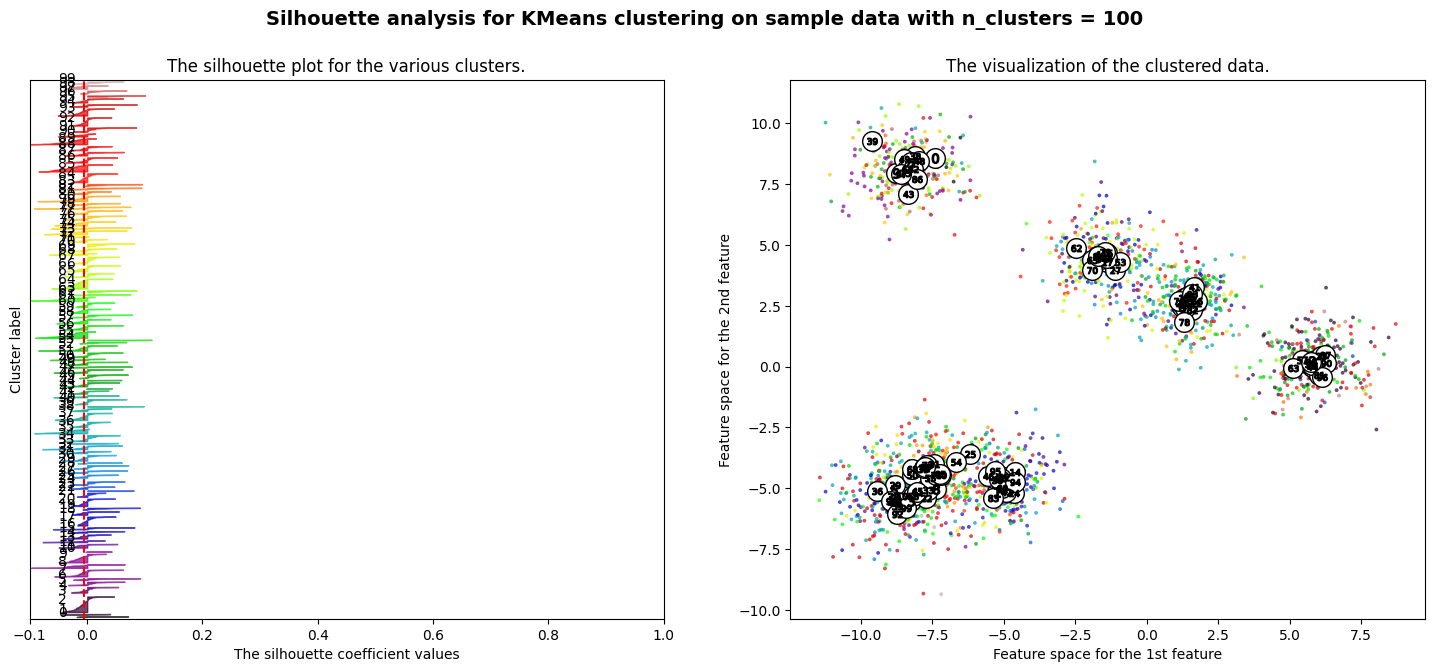

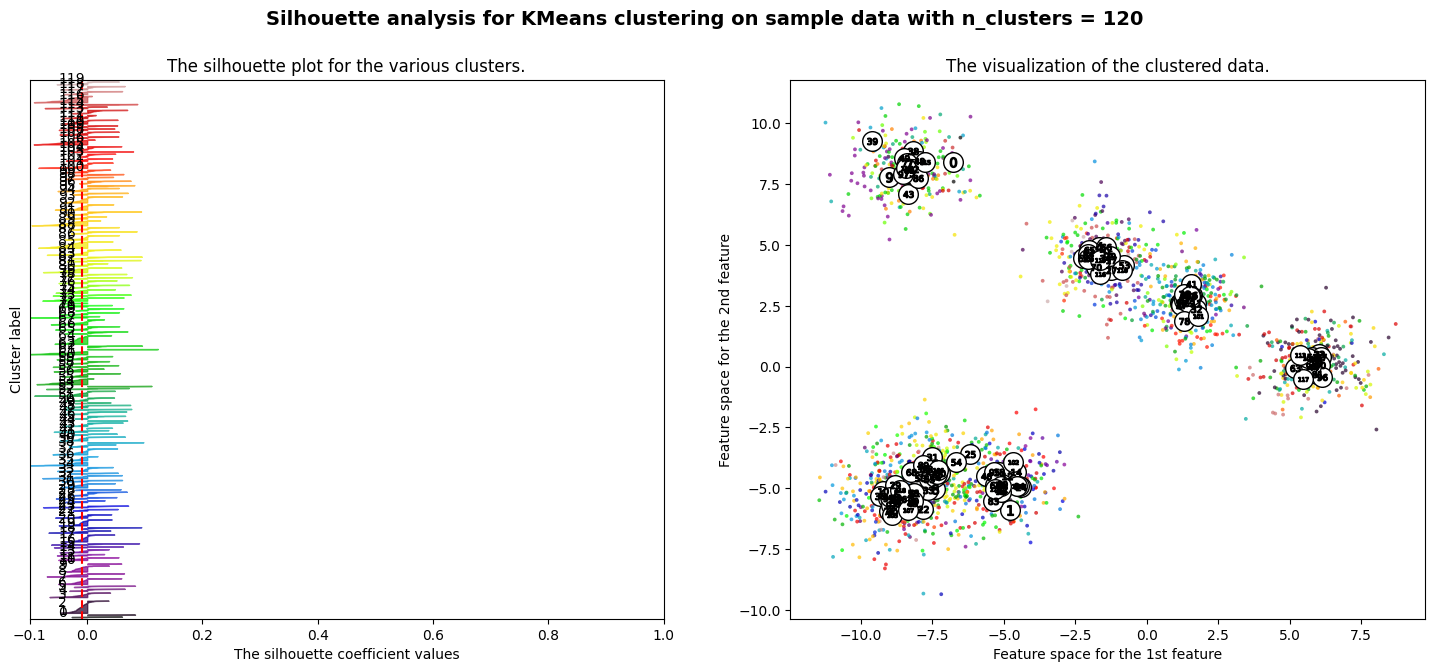

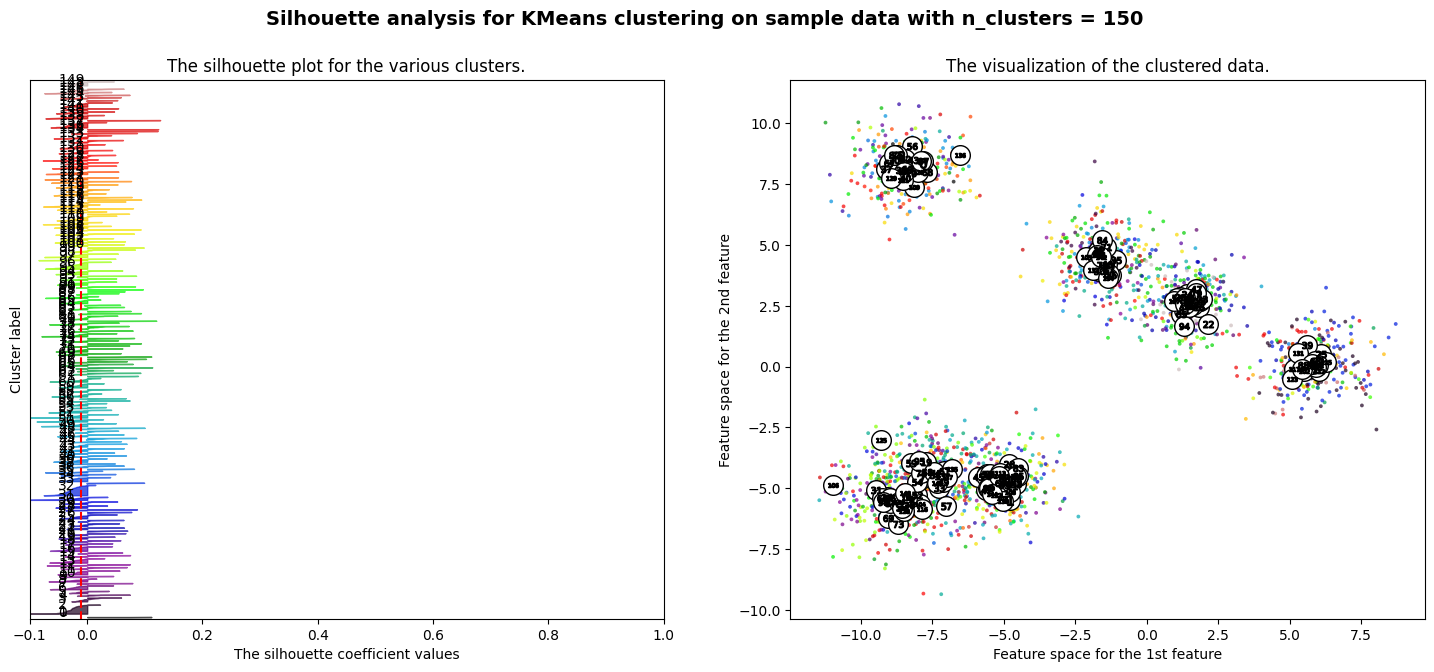

In [50]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=2000,
    n_features=128,
    centers=7,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [100, 120, 150]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

###HOG

In [61]:
image_list = []
class_list = []
for label in os.listdir(processed_ds):
  label_path = os.path.join(processed_ds, label)
  for image in [f for f in os.listdir(label_path) if f.endswith(('.jpg', '.png', '.jpeg'))]:
    image_path = os.path.join(label_path, image)
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, (180, 180), interpolation=cv.INTER_LINEAR)
    image_list.append(img)
    class_list.append(label)

In [62]:
class_list = np.array(class_list)

In [12]:
print(f"Size image list : {len(image_list)}")
print(f"Size class list : {len(class_list)}")

Size image list : 1373
Size class list : 1373


In [63]:
##HOG Descriptor
#Returns a 1D vector for an image
ppcr = 8
ppcc = 8
hog_images = []
hog_features = []
for image in image_list:
  blur = cv.GaussianBlur(image,(5,5),0) #Gaussian Filtering
  fd,hog_image = hog(blur, orientations=8, pixels_per_cell=(ppcr,ppcc),cells_per_block=(2,2),block_norm= 'L2',visualize=True)
  hog_images.append(hog_image)
  hog_features.append(fd)
hog_features = np.array(hog_features)
hog_features.shape

(1373, 14112)

In [38]:
edges = [cv.Canny(image,70,150,apertureSize = 3, L2gradient= True) for image in image_list]
edges = np.array(edges)
n_samples_edges = len(edges)
edge_images = edges.reshape((len(image_list), -1))
edge_images.shape

(1373, 50176)

In [39]:
histr = [cv.calcHist([img],[0],None,[256],[0,256]) for img in image_list]
histr = np.array(histr)
n_samples_histr = len(histr)
image_hist = histr.reshape((n_samples_histr, -1))
image_hist.shape

(1373, 256)

In [40]:
edge_hog = np.hstack([hog_features,edge_images,image_hist])
edge_hog.shape

(1373, 73760)

###Canny Edge Detection

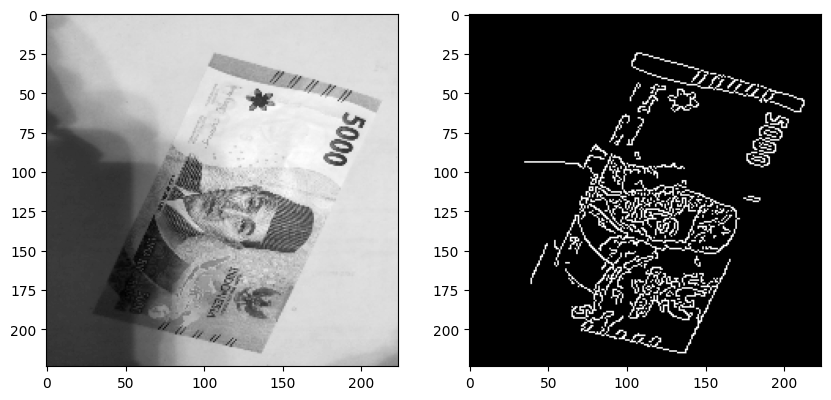

In [ ]:
# test canny detection on dataset
test_image_path = os.path.join(ds_path, '5000', 'test_2.jpeg')
test_image = plt.imread(test_image_path)
img = cv.imread(test_image_path, cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (224, 224))
t1 = 70
t2 = 150
aperture = 3
l2 = True
edges = cv.Canny(img, t1, t2, apertureSize=aperture, L2gradient=l2)
# plot original image and canny edge image side by side
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.show()

In [38]:


if not os.path.exists(processed_ds):
  os.mkdir(processed_ds)

label_list = os.listdir(ds_path)

def sortFunc(e):
  return int(e)

label_list.sort(key=sortFunc)
for label in label_list:
  label_path = os.path.join(ds_path, label)
  label_processed_path = os.path.join(processed_ds, label)
  if not os.path.exists(label_processed_path):
    os.mkdir(label_processed_path)
  else:
    #delete all file in this dir
    for img_file in os.listdir(label_processed_path):
      file_path = os.path.join(label_processed_path, img_file)
      os.remove(file_path)
  for image in [f for f in os.listdir(label_path) if f.endswith(('.jpg', '.png', '.jpeg'))]:
    image_path = os.path.join(label_path, image)
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    if img is None:
      print(f"Warning: Unable to read {image_path}. Skipping.")
      continue
    img = cv.resize(img, (224, 224))
    t1 = 70
    t2 = 150
    aperture = 3
    l2 = True
    edges = cv.Canny(img, t1, t2, apertureSize=aperture, L2gradient=l2)
    success = cv.imwrite(os.path.join(label_processed_path, image), edges)
    if success:
        print(f"Image successfully saved at: {os.path.join(label_processed_path, image)}")
    else:
        print(f"Failed to save image at: {os.path.join(label_processed_path, image)}")



Image successfully saved at: /content/drive/MyDrive/Semester 7/pcd/project/processed_ds/1000/WhatsApp Image 2023-04-25 at 10.59.49(7).jpeg
Image successfully saved at: /content/drive/MyDrive/Semester 7/pcd/project/processed_ds/1000/WhatsApp Image 2023-04-25 at 11.01.14(2).jpeg
Image successfully saved at: /content/drive/MyDrive/Semester 7/pcd/project/processed_ds/1000/WhatsApp Image 2023-04-25 at 11.01.09.jpeg
Image successfully saved at: /content/drive/MyDrive/Semester 7/pcd/project/processed_ds/1000/WhatsApp Image 2023-04-25 at 10.59.50(2).jpeg
Image successfully saved at: /content/drive/MyDrive/Semester 7/pcd/project/processed_ds/1000/WhatsApp Image 2023-04-25 at 11.01.13(2).jpeg
Image successfully saved at: /content/drive/MyDrive/Semester 7/pcd/project/processed_ds/1000/WhatsApp Image 2023-04-25 at 10.59.49(6).jpeg
Image successfully saved at: /content/drive/MyDrive/Semester 7/pcd/project/processed_ds/1000/WhatsApp Image 2023-03-04 at 22.02.10.jpeg
Image successfully saved at: /con

###Support Vector Machine

In [50]:
svc = SVC()
svc.fit(X_scaled, y_train)
svc_accuracy = svc.score(X_test, y_test)
print(f"SVM Accuracy: {rf_accuracy * 100:.2f}%")

SVM Accuracy: 16.73%


In [93]:
svc = SVC()
svc.fit(train_x, train_y)
svc_accuracy = svc.score(test_x, test_y)
print(f"SVM Accuracy: {rf_accuracy * 100:.2f}%")

SVM Accuracy: 42.86%


In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
svc_accuracy = svc.score(X_test, y_test)
print(f"SVM Accuracy: {rf_accuracy * 100:.2f}%")

SVM Accuracy: 43.75%


###bovw classification

In [61]:
train_y = list(bovw_train.keys())
train_x = list(bovw_train.values())
test_y = list(bovw_test.keys())
test_x = list(bovw_test.values())

In [89]:
# Prepare training data
train_x = []
train_y = []
for label, features in bovw_train.items():
    for feature in features:
        train_x.append(feature)
        train_y.append(label_dict[label]) # Get the numerical label using label_dict

# Prepare testing data
test_x = []
test_y = []
for label, features in bovw_test.items():
    for feature in features:
        test_x.append(feature)
        test_y.append(label_dict[label])

# Convert to numpy arrays
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [66]:
# dari hog
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt', criterion='gini')
rf_clf.fit(X_train_scaled, y_train)

rf_accuracy = rf_clf.score(X_test_scaled, y_test)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

Random Forest Accuracy: 14.55%


###KNN

In [90]:
# 1-NN algorithm. We use this for predict the class of test images.
# Takes 2 parameters. images is the feature vectors of train images and tests is the feature vectors of test images
# Returns an array that holds number of test images, number of correctly predicted images and records of class based images respectively
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}

    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key

            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]

# Call the knn function
results_bowl = knn(bovw_train, bovw_test)

In [91]:
# Calculates the average accuracy and class based accuracies.
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))

# Calculates the accuracies and write the results to the console.
accuracy(results_bowl)

Average accuracy: %41.49659863945578

Class based accuracies: 

1000 : %42.857142857142854
2000 : %42.857142857142854
5000 : %33.33333333333333
10000 : %61.904761904761905
20000 : %33.33333333333333
50000 : %23.809523809523807
100000 : %52.38095238095239
